<a href="https://colab.research.google.com/github/abdnafees/fastai-lesson4-hw/blob/master/fastai_lesson4_nlp_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

!curl -s https://course.fast.ai/setup/colab | bash
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 34.4MB/s 
Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
import os

In [0]:
from fastai.text import *
import numpy as np 
import pandas as pd 
from pathlib import Path

In [6]:
%cd /content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction

/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction


In [0]:
path = Path('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction')

In [8]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction/sample_submission.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction/test.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction/train.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/tweet-sentiment-extraction/tmp_lm')]

In [0]:
traindf = pd.read_csv(path/'train.csv')

In [10]:
traindf.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [11]:
testdf = pd.read_csv(path/'test.csv')
testdf.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [12]:
testdf['text'][1]

' Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).'

In [0]:
train = pd.DataFrame()
train = traindf[['textID' ,'text' , 'sentiment']]
test = pd.DataFrame()
test = testdf[['textID' , 'text' , 'sentiment']]

In [14]:
train.isnull().sum()

textID       0
text         1
sentiment    0
dtype: int64

In [15]:
train.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
trainlm = train.drop(columns=['textID'] )
testlm =  test.drop( columns=['textID'] )

In [17]:
trainlm.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [18]:
testlm.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


Deciding which databunch to use as Jeremy uses datablock API which is still confusing as he then uses TextLMDataBunch to load the earlier created databunch.
So, there are two ways to do it, one provides more control than the other.

In [0]:
# data_lm = (TextList.from_df(trainlm, path, cols='text')
#           .split_by_rand_pct()
#           .label_for_lm()
#           .databunch())
# data_lm.save('tmp_lm')

In [19]:
datalm = TextLMDataBunch.from_df(path, train_df = train, valid_df = testlm, max_vocab = 60000, min_freq = 1, bs = 64)

In [20]:
datalm.vocab.itos[:20]
datalm.show_batch()

idx,text
0,"some shameless plugging for the best xxmaj rangers forum on earth xxbos 2 am feedings for the baby are fun when he is all smiles and coos xxbos s xxrep 4 o high xxbos xxmaj both of you xxbos xxmaj journey ! ? xxmaj wow ... u just became cooler . hehe ... ( is that possible ! ? ) xxbos as much as i love to be hopeful ,"
1,"please pray 4 me . xxmaj lord knows i need it . xxbos xxrep 5 a w i want to live in the xxup usa xxbos xxmaj morning tweeple xxbos xxmaj hey , i didn`t get any ! ! ! xxbos xxmaj now you only have 2 hours to sleep ... - xxmaj rest if you need it . xxbos xxmaj that makes my day so much better , it`s"
2,updates are really amusing . xxmaj how was the prop auction?how much did that baseship bed go for ? xxbos xxmaj loves the fact that there`s only 5 days of school left xxbos xxmaj oh no ! ! i hope it`s not bad xxbos awesome .. am headin there that nite after my grad dinner c u then boi ! hehe xxbos _ beery xxmaj yeah little rough this morning
3,"maybe ride the horses and take my sister to softball pratice xxbos xxmaj nice ! xxmaj you should submit that to failblog.org xxbos xxmaj is ahhh , ching chong wing wong ping pong ding dong ! xxbos has two tickets to xxmaj amadou and xxmaj miriam for xxmaj tue . xxmaj june 2 that i can`t use $ 25 each to anyone who wants ` em . xxmaj that`s face"
4,kyles going out of town this weekend play time wif my fwiends . xxmaj rawrrr . xxbos gah ! didn`t realize my meeting was from 9 - 12 xxbos needs a job xxbos is satisfied with her xxup fp`09 review xxbos cuz i m a always late haha dammit she got me good xxbos - i know ! xxmaj it was drizzling all the way to work ! xxmaj hope


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'i',
 '!',
 'to',
 'the',
 ',',
 'a',
 'my',
 'and',
 'you',
 '/']

In [0]:
# from fastai import *
# bs = 32
# data_lm = load_data(path, 'tmp_lm', bs=bs)

In [0]:
# data_lm = TextLMDataBunch.load(path, 'tmp_lm')

In [26]:
learn = language_model_learner(datalm, AWD_LSTM, drop_mult=0.3)

In [27]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


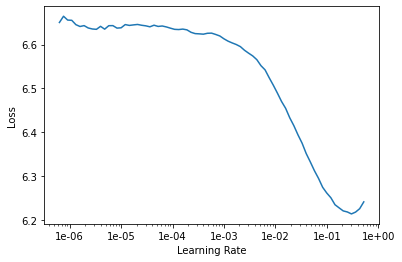

In [28]:
learn.recorder.plot(skip_end=15)

In [30]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.751620,4.803140,0.105915,00:16
1,4.686171,4.826179,0.107366,00:16


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head')

In [0]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(4, 3e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.423282,10.410120,0.000000,00:20
1,2.697317,9.552915,0.000223,00:20
2,2.224940,10.287794,0.000335,00:20
3,1.769128,10.687942,0.000112,00:20


In [38]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.353795,9.187529,0.001563,00:20
1,4.817420,8.480739,0.202121,00:20
2,4.595346,8.572481,0.202344,00:20
3,4.128438,8.854847,0.202009,00:20


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [43]:
learn.predict('I liked this movie because', 100, temperature=1.1, min_p=0.001)

'I liked this movie because F1 is a BIG ! ! So funny ... can`t sleep We see today ! ! ! http : / / bit.ly / 21CU xxbos getting ready to do some work out though so i m not . sigh , but i have a headache today xxbos i only m now sitting here on the show for the bus xxbos On our way to LA . Have to drive on our house on the road coast ( via ) as well xxbos Do you think ... ? http : / /'

In [0]:
learn.save_encoder('fine_tuned_enc')

In [46]:
dataclas = TextClasDataBunch.from_df(path, train_df = train, valid_df = testlm, vocab=datalm.vocab, max_vocab = 60000, min_freq = 1, bs = 50, label_cols='sentiment', text_cols='text')

In [47]:
dataclas.show_batch()

text,target
"xxbos xxmaj legend of xxmaj inotia xxrep 7 ? xxrep 6 ? . xxrep 6 ? xxrep 7 ? . xxrep 4 ? xxrep 7 ? 31 ? xxrep 5 ? , xxrep 5 ? xxrep 6 ? ? ? ? . xxrep 9 ? xxrep 4 ? xxrep 6 ? xxrep 5 ? xxrep 7 ? xxrep 10 ?",neutral
"xxbos xxmaj yeah xxmaj it xxmaj good xxmaj but do nt xxmaj click xxmaj the xxmaj red x xxmaj because xxmaj it xxmaj shuts xxmaj it xxmaj down xxmaj but xxmaj other xxmaj then xxmaj that xxmaj its xxmaj good xxmaj and xxmaj when u minimize xxmaj it , xxmaj it xxmaj goes ..",positive
xxbos xxup ya i xxup just xxup got a xxup twitt xxup from xxup somebody xxup sayin xxup it xxup looks xxup like xxup its xxup gonna xxup rain xxup out xxup here xxup on xxup the xxup west xxup coast .. i xxup aint xxup been xxup outside xxup yet .,neutral
xxbos i xxup jus xxup found xxup my xxup i.d. xxup finally ; xxup it xxup was xxup in xxup the xxup lint xxup thingy xxup in xxup the xxup dryer xxup lol xxup its xxup all xxup bent xxup outta xxup shape xxup now xxup im xxup mad,negative
"xxbos xxup keri xxup hilson- xxup slow xxup dance xxup rockin ` xxup the xxrep 4 * xxup out xxup of xxup my xxup playlist xxup right xxup now ! xxup get xxup up xxup on xxup this xxup song , xxup pure xxrep 4 * xxup dropper",positive


In [0]:
learn = text_classifier_learner(dataclas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [53]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


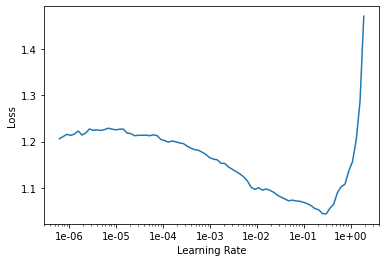

In [54]:
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(2, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.888620,0.819652,0.631862,00:11
1,0.821522,0.790920,0.648840,00:11


In [0]:
learn.save('first_clas')

In [0]:
learn.load('first_clas');

In [0]:
learn.freeze_to(-2)

In [61]:
learn.fit_one_cycle(3, slice(2e-3, 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.699281,0.664358,0.728070,00:13
1,0.664349,0.644242,0.732881,00:14
2,0.559515,0.643610,0.731466,00:14


In [0]:
learn.freeze_to(-3)

In [63]:
learn.fit_one_cycle(3, slice(5e-3/2.6**4, 5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.552602,0.652751,0.732881,00:18
1,0.545565,0.643104,0.739672,00:20
2,0.475354,0.665513,0.730334,00:20


In [0]:
learn.save('second_clas')

In [0]:
learn.load('second_clas');

In [67]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/2.6**4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.456061,0.677894,0.734578,00:27
1,0.443486,0.676751,0.734295,00:25


In [0]:
learn.save('third_clas')

In [70]:
learn.predict('My ridiculous dog is amazing')

(Category tensor(2), tensor(2), tensor([0.0471, 0.1082, 0.8447]))